# Naive Bayes Classifier

In [151]:
import pandas as pd
import numpy as np

In [152]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

## Preprocessing Pipeline

In [153]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

In [154]:
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

## Preprocessing Pipeline

In [155]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 


In [156]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', "passthrough", cat_features)
    ])

## Naive Bayes Classifier Model

In [157]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTEENN,  SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

In [158]:
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampling', RandomOverSampler(sampling_strategy=0.35, random_state=42)),
    ('clf', GaussianNB())
])

param_grid = {
    'clf__var_smoothing': np.logspace(0,-9, num=100)
}

scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, refit='f1')
grid_search.fit(train_data, train_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['climb_total',
                                                                          'cyclist_age',
                                                                          'cyclist_level',
                                                                          'cyclist_experience',
                                                                          'avg_relative_position',
                                                                          'position_entropy',
                                                                          'top_20_entropy']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         [])])),
                                       ('resampling',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy=0.35)),
                                       ('clf...
                      'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                      'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                      'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                      'specificity': make_scorer(specificity_score, response_method='predict')})

## Model Assessment

### Validation scores:

In [159]:
# extract the results of the randomized search and best model idx
cv_results = grid_search.cv_results_
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.4348, Std: 0.0085
Specificity - Mean: 0.8344, Std: 0.0013
Accuracy - Mean: 0.7813, Std: 0.0009
Precision - Mean: 0.2868, Std: 0.0032
Recall - Mean: 0.4348, Std: 0.0085
Roc_auc - Mean: 0.7165, Std: 0.0033
F1 - Mean: 0.3456, Std: 0.0049


### Test scores:

Accuracy: 0.699
Recall: 0.528
Precision: 0.251
Sensitivity: 0.528
Specificity: 0.729
F1 Score: 0.34
ROC AUC Score: 0.628


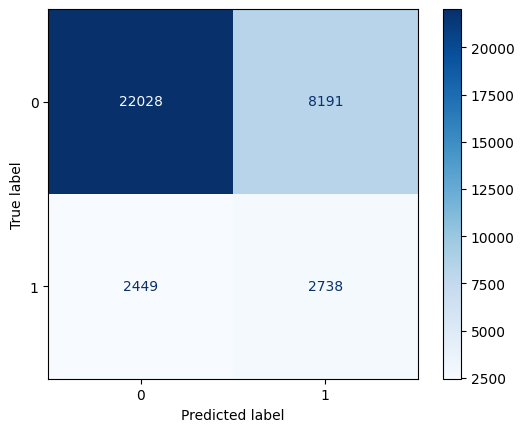

In [160]:
# Predict on the test data
test_predictions = grid_search.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [161]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.73      0.81     30219
           1       0.25      0.53      0.34      5187

    accuracy                           0.70     35406
   macro avg       0.58      0.63      0.57     35406
weighted avg       0.80      0.70      0.74     35406



In [162]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/nb.pkl')

['best_models/nb.pkl']

In linea generale over sampling o undersampling o tecniche che combinano i due non cambiano quasi di nulla i risultati ottenuti dal modello. Quello che è possibile osservare è che usando una tecnica di resampling o non usandola il modello passa da performance più bilanciate a perfomrance molto più sbilanciate, migliorando le sue capacità generale sulla classe 1. Visto che il metodo di resampling non cambia i risultati ottenuti dal modello per la scelta del miglior modello optiamo per random over sampling che permette di avere il miglior trade off tra performance e tempi di esecuzione. Dopo aver fissato l'oversampler abbiamo finetunato a mano il parametro di resampling in modo da ottenere il modello migliore